# Bus 68 RATP (IDFM) OpenData

This notebook is used to analyze and plot graphs on top of the STIF/IDFM OpenData collection over a few days.

In [1]:
%matplotlib notebook

In [2]:
import collections
import datetime
import math
import os
import sys

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import peewee

from playhouse.db_url import connect

In [3]:
# Initialize db
db = connect('sqlite:///bus_68_datapoints.db')


class DataPoint(peewee.Model):
    class Meta:
        database = db

    datetime = peewee.DateTimeField(
        default=datetime.datetime.now()
    )
    lineDirection = peewee.CharField(max_length=255)
    code = peewee.CharField(max_length=255)
    time = peewee.CharField(max_length=255)

In [4]:
db.connect()

True

In [5]:
# Get first and last day in the dataset
first_dp = DataPoint().select().order_by(DataPoint.datetime.asc()).first()
first_day = first_dp.datetime.replace(
    hour=0, minute=0, second=0, microsecond=0
)

last_dp = DataPoint().select().order_by(DataPoint.datetime.desc()).first()
last_day = last_dp.datetime.replace(
    hour=0, minute=0, second=0, microsecond=0
)

# Remove first and last day as they are likely not complete in the dataset
first_day += datetime.timedelta(days=1)
last_day -= datetime.timedelta(days=1)

first_day, last_day

(datetime.datetime(2018, 9, 25, 0, 0), datetime.datetime(2018, 12, 12, 0, 0))

In [6]:
# Truncate data
first_day = datetime.datetime(
    year=2018, month=11, day=1,
    hour=0, minute=0, second=0, microsecond=0
)
last_day = datetime.datetime(
    year=2018, month=12, day=1,
    hour=0, minute=0, second=0, microsecond=0
)
first_day, last_day

(datetime.datetime(2018, 11, 1, 0, 0), datetime.datetime(2018, 12, 1, 0, 0))

In [7]:
# Line direction to filter on
LINE_DIRECTION = "Chatillon Montrouge"
# Dictionnary mapping days to a dict of list of datetimes
# for at stops, approaching, possibly missed and waiting times
processed_data = {}

day = first_day
while day <= last_day:
    print(day)
    
    # Get all the datapoints for the current day
    next_day = day + datetime.timedelta(days=1)
    day_dps = DataPoint().select().where(
        (DataPoint.datetime >= day) &
        (DataPoint.datetime < next_day) &
        (DataPoint.lineDirection == LINE_DIRECTION)
    ).order_by(DataPoint.datetime.asc())

    processed_data[day] = {}
    processed_data[day]['at_stop_datetimes'] = []
    processed_data[day]['at_approach_datetimes']  = []
    processed_data[day]['possibly_missed_datetimes'] = []
    processed_data[day]['waiting_times'] = []  # Tuples of datetimes and waiting times
    current_waiting_time = math.inf
    
    # Group items by datetimes since there are two times
    # (for next bus and next next bus) returned at every moment by the API
    day_dps_by_datetimes = collections.defaultdict(list)
    for item in day_dps:
        # TODO: We should be able to detect multiple buses coming at the same time here
        day_dps_by_datetimes[item.datetime].append(item)
    
    for dt in day_dps_by_datetimes.keys():
        selected_item = day_dps_by_datetimes[dt][0]  # Default to first item choosen
        for item in day_dps_by_datetimes[dt]:
            if "arrêt" in selected_item.time:
                # If selected item is "at stop", just keep this one
                continue

            if "arrêt" in item.time or "approche" in item.time:
                # Else, if the looped item is at stop or approaching, pick it
                selected_item = item
            elif "approche" not in selected_item.time and int(item.time) < int(selected_item.time):
                # Else, only keep it if current waiting time is the lowest one
                selected_item = item
        
        if "arrêt" in selected_item.time:
            # Bus at stop, note the time in the "at stop" list
            processed_data[day]['at_stop_datetimes'].append(selected_item.datetime)
            current_waiting_time = math.inf
            processed_data[day]['waiting_times'].append((selected_item.datetime, 0))
        elif "approche" in selected_item.time:
            # Bus approaching, note the time in the "approaching" list
            processed_data[day]['at_approach_datetimes'].append(selected_item.datetime)
            current_waiting_time = 0
            processed_data[day]['waiting_times'].append((selected_item.datetime, 0))
        else:
            # Else, check the current expected duration
            new_current_waiting_time = int(selected_item.time)
            if current_waiting_time > 0 and current_waiting_time < new_current_waiting_time:
                # We might have missed a bus
                processed_data[day]['possibly_missed_datetimes'].append(selected_item.datetime)
            # Update current duration and store current waiting times
            current_waiting_time = new_current_waiting_time
            processed_data[day]['waiting_times'].append((selected_item.datetime, current_waiting_time))
    
    day = next_day
    
print('Done!')

2018-11-01 00:00:00
2018-11-02 00:00:00
2018-11-03 00:00:00
2018-11-04 00:00:00
2018-11-05 00:00:00
2018-11-06 00:00:00
2018-11-07 00:00:00
2018-11-08 00:00:00
2018-11-09 00:00:00
2018-11-10 00:00:00
2018-11-11 00:00:00
2018-11-12 00:00:00
2018-11-13 00:00:00
2018-11-14 00:00:00
2018-11-15 00:00:00
2018-11-16 00:00:00
2018-11-17 00:00:00
2018-11-18 00:00:00
2018-11-19 00:00:00
2018-11-20 00:00:00
2018-11-21 00:00:00
2018-11-22 00:00:00
2018-11-23 00:00:00
2018-11-24 00:00:00
2018-11-25 00:00:00
2018-11-26 00:00:00
2018-11-27 00:00:00
2018-11-28 00:00:00
2018-11-29 00:00:00
2018-11-30 00:00:00
2018-12-01 00:00:00
Done!


<IPython.core.display.Javascript object>


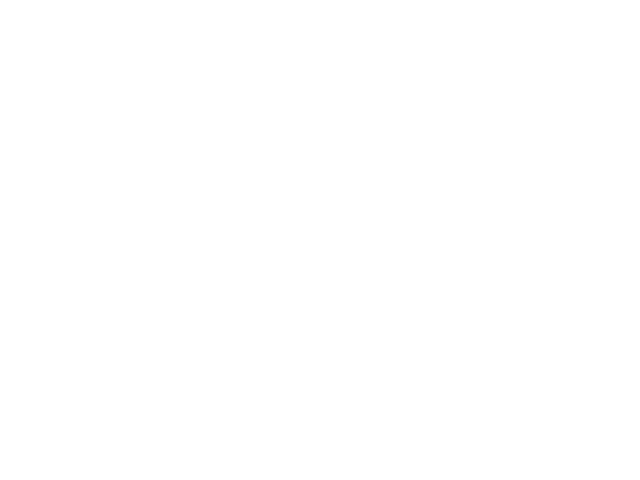

<IPython.core.display.Javascript object>


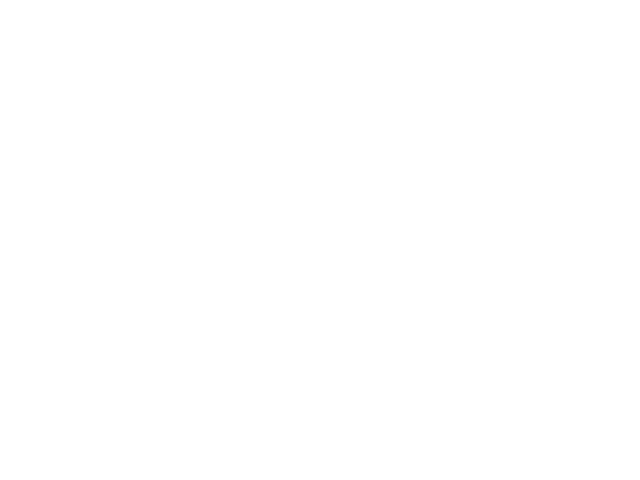

<IPython.core.display.Javascript object>


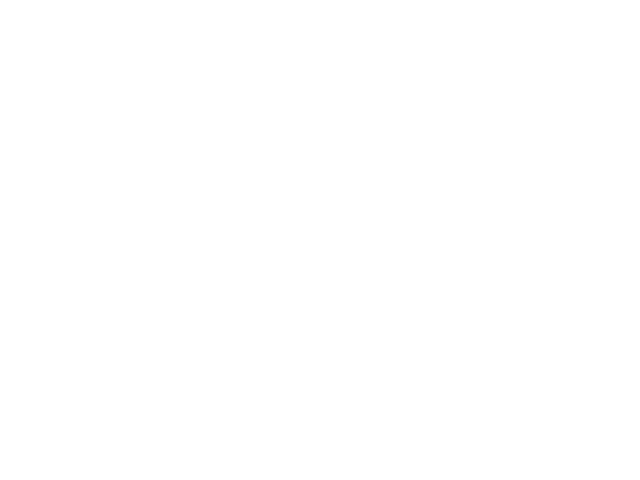

<IPython.core.display.Javascript object>


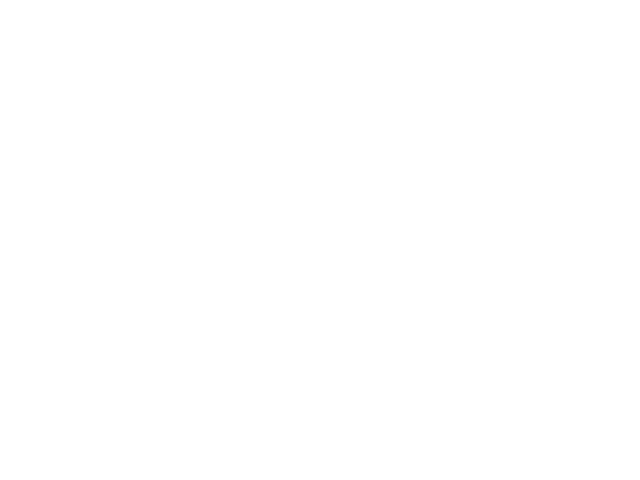

<IPython.core.display.Javascript object>


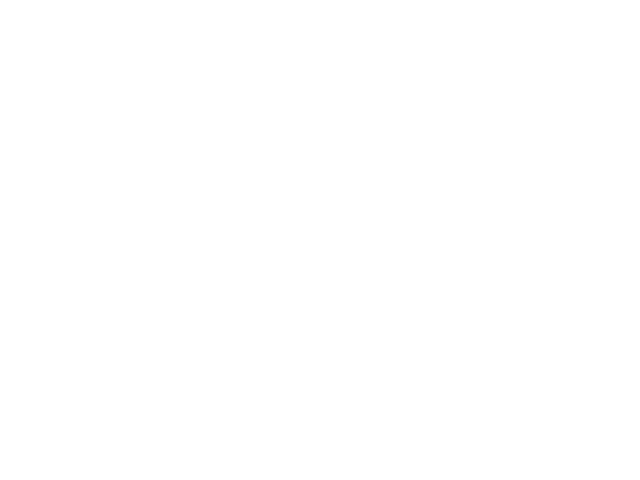

<IPython.core.display.Javascript object>


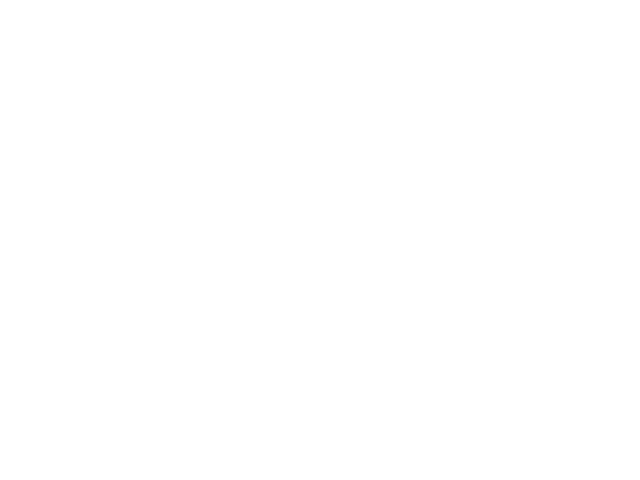

<IPython.core.display.Javascript object>


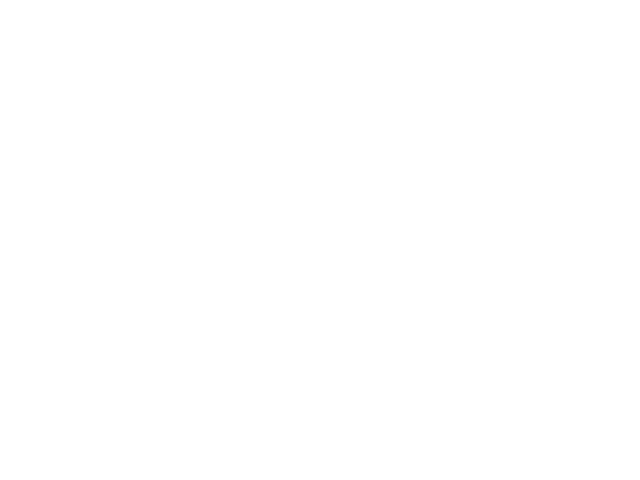

<IPython.core.display.Javascript object>


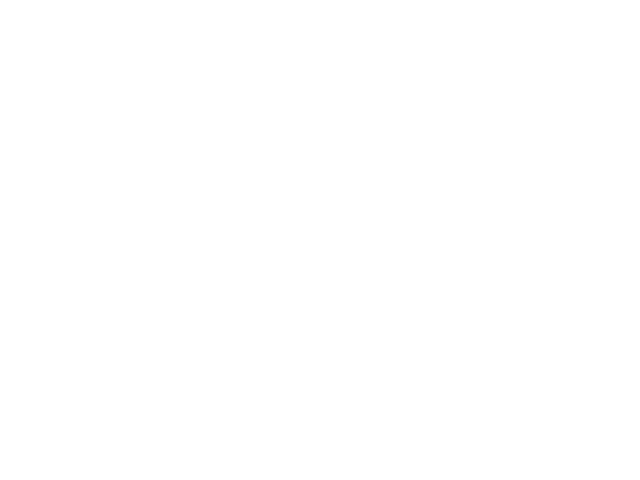

<IPython.core.display.Javascript object>


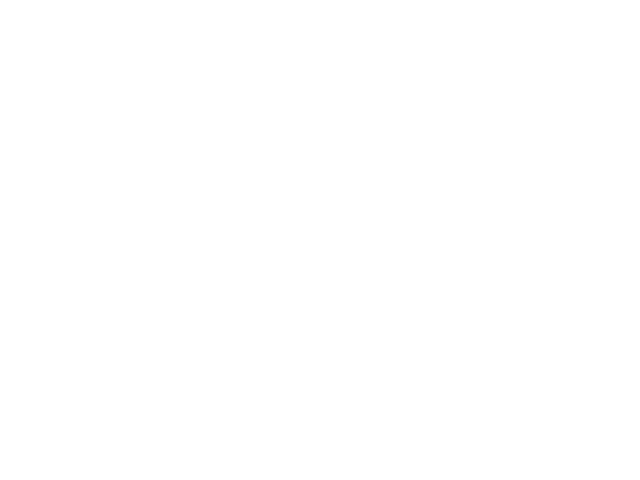

<IPython.core.display.Javascript object>


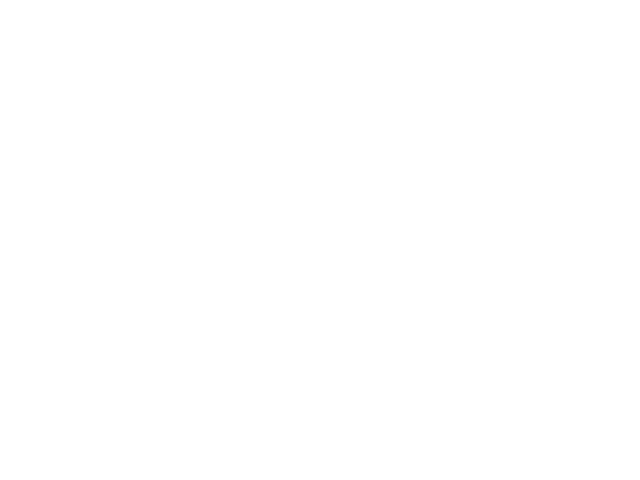

<IPython.core.display.Javascript object>


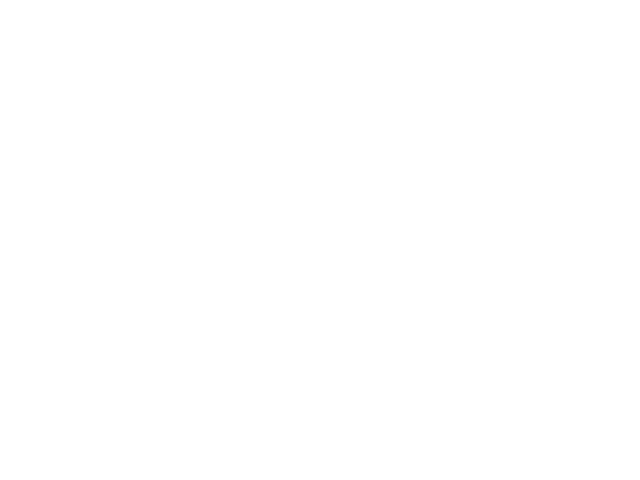

<IPython.core.display.Javascript object>


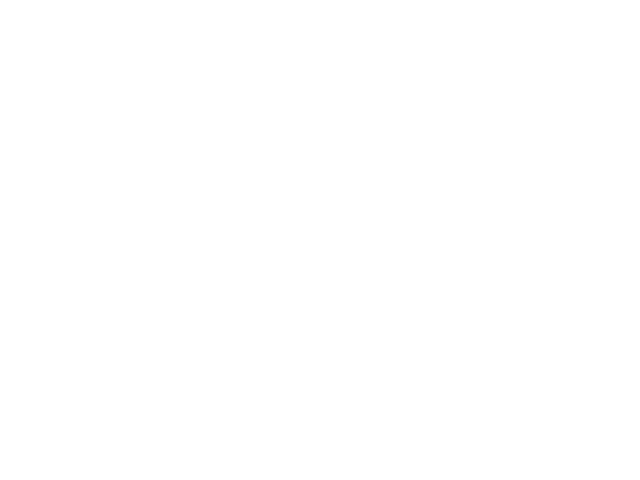

<IPython.core.display.Javascript object>


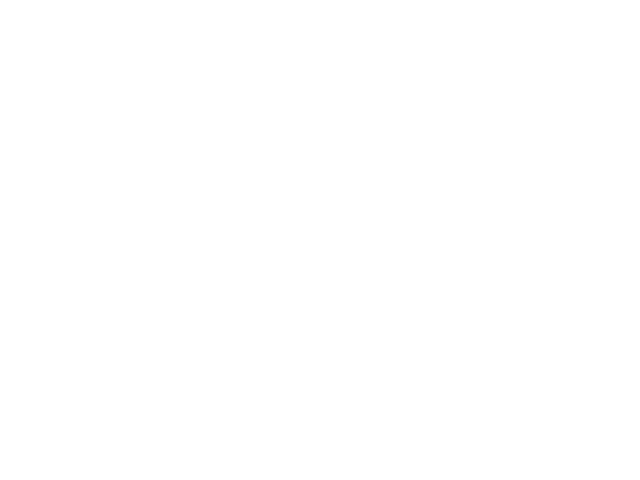

<IPython.core.display.Javascript object>


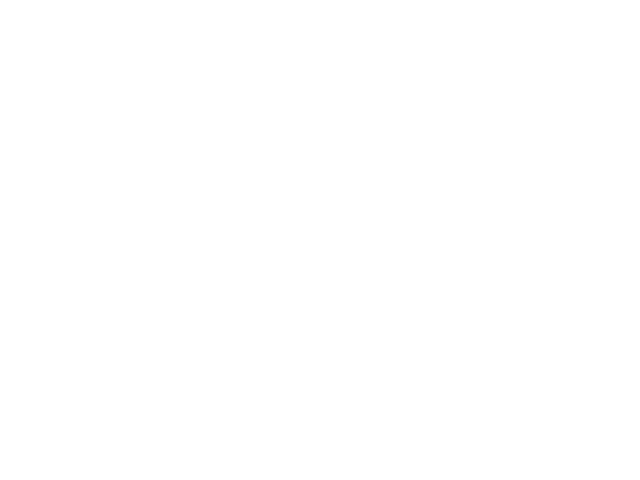

<IPython.core.display.Javascript object>


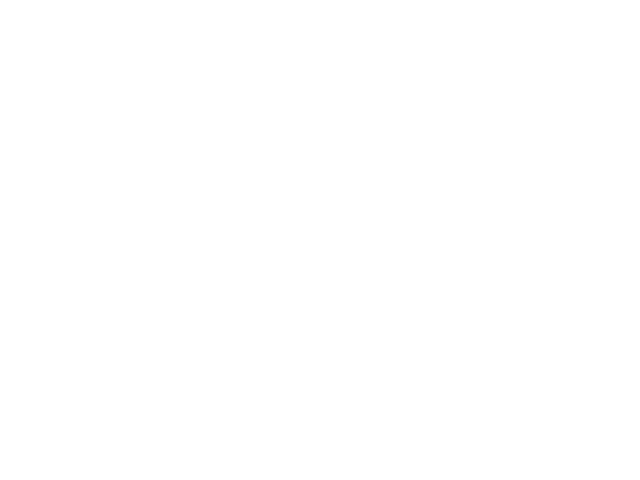

<IPython.core.display.Javascript object>


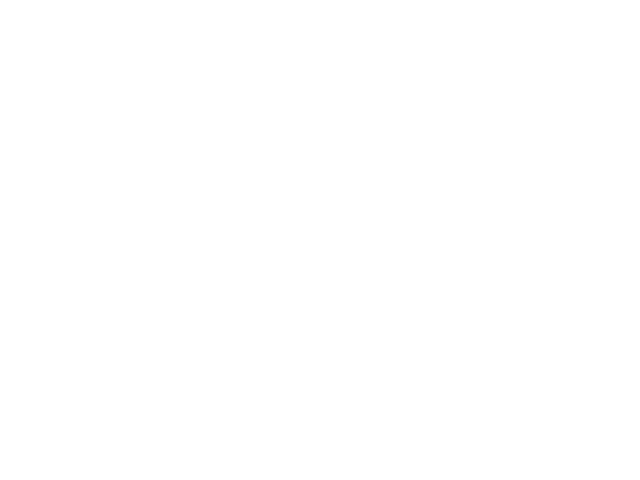

<IPython.core.display.Javascript object>


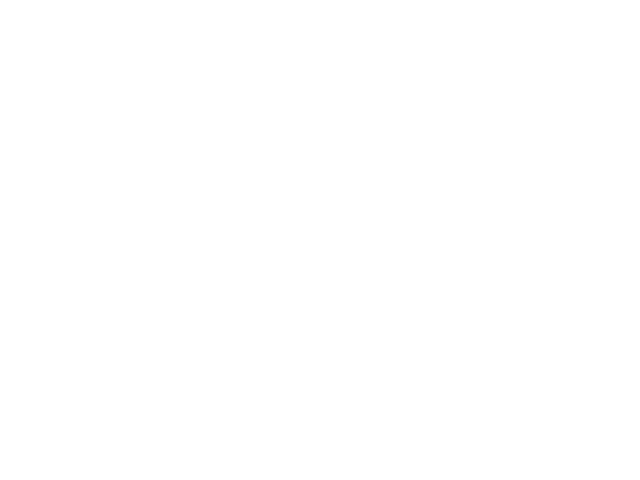

<IPython.core.display.Javascript object>


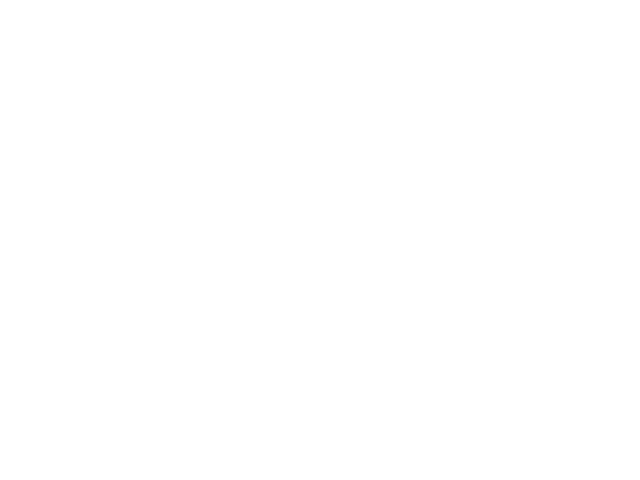

<IPython.core.display.Javascript object>


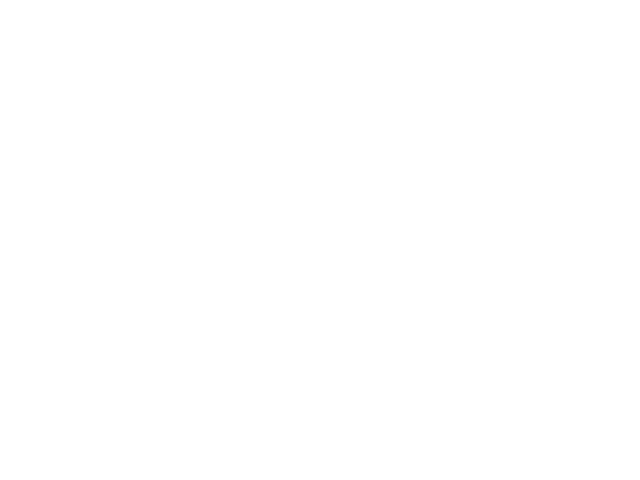

<IPython.core.display.Javascript object>


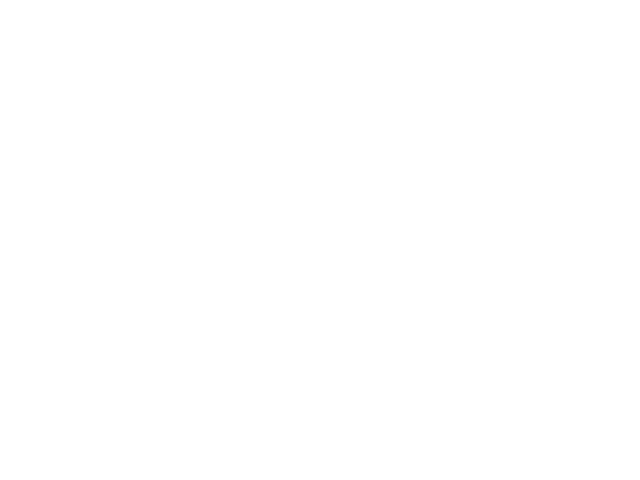

<IPython.core.display.Javascript object>


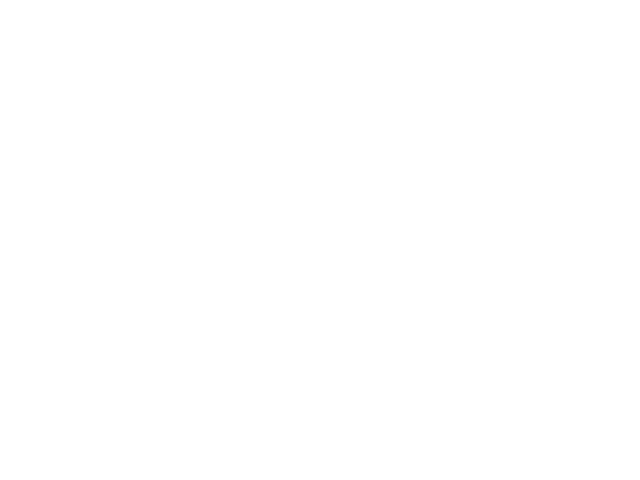

In [8]:
day = first_day

while day <= last_day:
    # Only plot weekdays between 7:00 and 20:30
    if (
        day.weekday() >= 5 or
        # Ignore public holidays in the interval
        (day.day == 1 and day.month == 11) or
        (day.day == 11 and day.month == 11)
    ):
        day += datetime.timedelta(days=1)
        continue
    min_datetime = day.replace(hour=7, minute=0)
    max_datetime = day.replace(hour=20, minute=30)
    
    fig, ax = plt.subplots()
    ax.set_title(day.strftime('%d/%m/%Y'))
    # Format dates nicely on x axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    # Plot the graph of waiting times
    all_datetimes = [x[0] for x in processed_data[day]['waiting_times']
                     if x[0] > min_datetime and x[0] < max_datetime]
    waiting_times = [x[1] for x in processed_data[day]['waiting_times']
                     if x[0] > min_datetime and x[0] < max_datetime]
    ax.plot(all_datetimes, waiting_times)
    ax.set_ylim((0, max(waiting_times) + 5))
    ax.set_xlabel('Heure')
    ax.set_ylabel('Temps d\'attente (en min)')

    bus_is_here_datetimes = sorted(
        processed_data[day]['at_stop_datetimes'] + processed_data[day]['at_approach_datetimes']
    )
    filtered_bus_is_here_datetimes = []
    for i, item in enumerate(bus_is_here_datetimes):
        if i < len(bus_is_here_datetimes) - 1 and (bus_is_here_datetimes[i + 1] - item).total_seconds() <= 61:
            continue
        filtered_bus_is_here_datetimes.append(item)

    for at_stop_dt in filtered_bus_is_here_datetimes:
        ax.annotate('', (mdates.date2num(at_stop_dt), max(waiting_times)), xytext=(0, 20), 
                    textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
    for possibly_missed_dt in processed_data[day]['possibly_missed_datetimes']:
        ax.annotate('', (mdates.date2num(possibly_missed_dt), max(waiting_times)), xytext=(0, 20), 
                textcoords='offset points', arrowprops=dict(arrowstyle='-|>', edgecolor='red', facecolor='red'))
    fig.savefig(day.strftime('%d_%m_%Y.pdf'))
    plt.close(fig)
    day += datetime.timedelta(days=1)

In [9]:
# Compute the delay between two successive bus for
# each period of the day as defined in the timetables.
day = first_day

hist_at_stop_datetimes_per_day = {}
while day <= last_day:
    # 2017 - September to June times
    # https://www.ratp.fr/sites/default/files/fiches-horaires/busratp/68.pdf
    hist_at_stop_datetimes_per_day[day] = {
        "before_7:00": [],
        "7:00_to_20:30": [],
        "20:30_to_21:30": [],
        "after_21:30": []
    }

    bus_is_here_datetimes = sorted(
        processed_data[day]['at_stop_datetimes'] + processed_data[day]['at_approach_datetimes']
    )
    for prev_index, item in enumerate(bus_is_here_datetimes[1:]):
        total_seconds = item.hour * 3600 + item.minute
        if total_seconds < 7 * 3600 + 0:
            key = "before_7:00"
        elif total_seconds < 20 * 3600 + 30:
            key = "7:00_to_20:30"
        elif total_seconds < 21 * 3600 + 30:
            key = "20:30_to_21:30"
        else:
            key = "after_21:30"

        hist_at_stop_datetimes_per_day[day][key].append(
            (item - bus_is_here_datetimes[prev_index]).total_seconds()
        )
    day += datetime.timedelta(days=1)

<IPython.core.display.Javascript object>


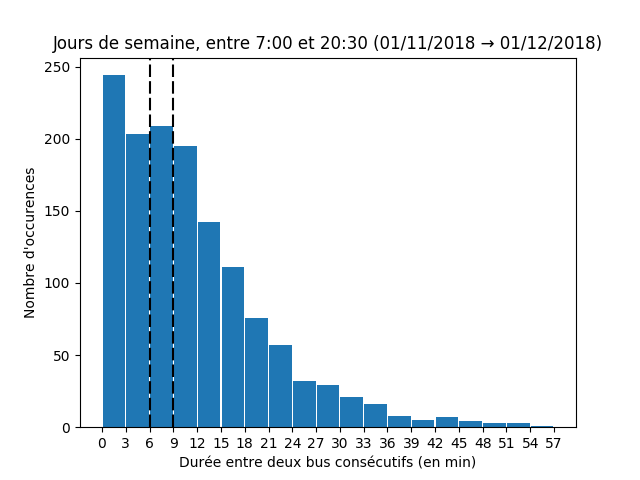

In [13]:
fig, ax = plt.subplots()

# Distinguish between week, saturday and sunday as does the timetable.
hist_at_stop_datetimes_week = {
    "before_7:00": [],
    "7:00_to_20:30": [],
    "20:30_to_21:30": [],
    "after_21:30": []
}
hist_at_stop_datetimes_saturday = {
    "before_7:00": [],
    "7:00_to_20:30": [],
    "20:30_to_21:30": [],
    "after_21:30": []
}
hist_at_stop_datetimes_sunday = {
    "before_7:00": [],
    "7:00_to_20:30": [],
    "20:30_to_21:30": [],
    "after_21:30": []
}
day = first_day
while day <= last_day:
    if day.weekday() < 5:
        d = hist_at_stop_datetimes_week
    elif day.weekday() == 5:
        d = hist_at_stop_datetimes_saturday
    elif day.weekday() == 6:
        d = hist_at_stop_datetimes_sunday
    elif (day.day == 1 and day.month == 11) or (day.day == 11 and day.month == 11):
        # Public holidays are the same as Sunday for schedules
        d = hist_at_stop_datetimes_sunday
    
    d["before_7:00"].extend(hist_at_stop_datetimes_per_day[day]["before_7:00"])
    d["7:00_to_20:30"].extend(hist_at_stop_datetimes_per_day[day]["7:00_to_20:30"])
    d["20:30_to_21:30"].extend(hist_at_stop_datetimes_per_day[day]["20:30_to_21:30"])
    d["after_21:30"].extend(hist_at_stop_datetimes_per_day[day]["after_21:30"])
    
    day += datetime.timedelta(days=1)

# Plot the histogram of all values for weekdays between 7:00 and 20:30 for instance
# Note: We drop the times below 1 minute as this
# is likely to be the same bus still at the stop
# (or two buses in a row, which could be argued to be basically the same).
n, bins, _ = ax.hist(
    [
        x / 60
        for x in hist_at_stop_datetimes_week["7:00_to_20:30"]
        if x > 61
    ],
    bins=[3 * i for i in range(20)],
    rwidth=0.95
)
ax.set_xticks([3 * i for i in range(20)])
ax.axvline(x=6, color='black', dashes=[6, 2])
ax.axvline(x=9, color='black', dashes=[6, 2])
ax.set_xlabel('Durée entre deux bus consécutifs (en min)')
ax.set_ylabel('Nombre d\'occurences')
ax.set_title(
    'Jours de semaine, entre 7:00 et 20:30 (%s → %s)' %
    (first_day.strftime('%d/%m/%Y'), last_day.strftime('%d/%m/%Y'))
)
fig.show()

In [11]:
# Get the details of the histogram with percentages
bins_show = []
for k in range(len(bins) - 1):
    bins_show.append('%.2f - %.2f' % (bins[k], bins[k+1]))

total_sum = sum(n)
collections.OrderedDict(
    (b, '%d %%' % int(count / total_sum * 100)) for (b, count) in zip(bins_show, n)
)

OrderedDict([('0.00 - 3.00', '17 %'),
             ('3.00 - 6.00', '14 %'),
             ('6.00 - 9.00', '15 %'),
             ('9.00 - 12.00', '14 %'),
             ('12.00 - 15.00', '10 %'),
             ('15.00 - 18.00', '8 %'),
             ('18.00 - 21.00', '5 %'),
             ('21.00 - 24.00', '4 %'),
             ('24.00 - 27.00', '2 %'),
             ('27.00 - 30.00', '2 %'),
             ('30.00 - 33.00', '1 %'),
             ('33.00 - 36.00', '1 %'),
             ('36.00 - 39.00', '0 %'),
             ('39.00 - 42.00', '0 %'),
             ('42.00 - 45.00', '0 %'),
             ('45.00 - 48.00', '0 %'),
             ('48.00 - 51.00', '0 %'),
             ('51.00 - 54.00', '0 %'),
             ('54.00 - 57.00', '0 %')])

In [12]:
# Compute the percentage of buses on time according to the timetable
# Note: We drop the times below 1 minute as this
# is likely to be the same bus still at the stop
# (or two buses in a row, which could be argued to be basically the same).
(len([
    x / 60
    for x in hist_at_stop_datetimes_week["7:00_to_20:30"]
    if x > 61 and x < 9 * 60
]) / len([
    x / 60
    for x in hist_at_stop_datetimes_week["7:00_to_20:30"]
    if x > 61
])) * 100

47.53623188405797